# Introducción

Este notebook implementa un **Deep Q-Network (DQN)** para resolver el problema de aterrizaje lunar utilizando el entorno **LunarLander-v3** de *Gymnasium*.
El objetivo es entrenar un agente que aprenda a aterrizar una nave espacial de forma **segura y eficiente**.

---

# El Problema: Lunar Lander

El **Lunar Lander** es un juego clásico donde el objetivo es aterrizar una nave espacial en una plataforma de aterrizaje.
La nave debe:

- Controlar su velocidad y posición
- Evitar chocar contra el suelo
- Minimizar el uso de combustible
- Aterrizar suavemente en la zona designada

---

## Especificaciones Técnicas

### Espacio de Acciones

- **Tipo:** Discreto (4 acciones)
  - `0`: No hacer nada
  - `1`: Disparar motor principal (empuje hacia arriba)
  - `2`: Disparar motor izquierdo (empuje hacia la derecha)
  - `3`: Disparar motor derecho (empuje hacia la izquierda)

---

### Espacio de Observaciones

- **Dimensión:** 8 variables continuas

1. Posición **X**: Coordenada horizontal `(-2.5 a 2.5)`
2. Posición **Y**: Coordenada vertical `(-2.5 a 2.5)`
3. Velocidad **X**: Velocidad horizontal `(-10 a 10)`
4. Velocidad **Y**: Velocidad vertical `(-10 a 10)`
5. **Ángulo**: Orientación de la nave `(-π a π)`
6. Velocidad **Angular**: Velocidad de rotación `(-10 a 10)`
7. **Pata Izquierda**: Contacto con el suelo `(0 o 1)`
8. **Pata Derecha**: Contacto con el suelo `(0 o 1)`

### Sistema de Recompensas

- **Aterrizaje exitoso:** +100 a +140 puntos (dependiendo de la suavidad)
- **Crash:** -100 puntos
- **Uso de motores:** Penalización por combustible usado
- **Distancia a la plataforma:** Recompensa por proximidad
- **Velocidad:** Penalización por alta velocidad


### Estados Finales

- **Éxito:** Aterrizaje suave en la plataforma
- **Crash:** Colisión con el terreno
- **Timeout:** Superar el límite de pasos (típicamente 1000)


In [14]:
import gymnasium as gym
import torch.nn as nn
import torch
from collections import deque
import random
from pathlib import Path
from torch import optim
import numpy as np
from datetime import datetime
import json
import csv
import os

# ¿Por qué DQN?

Se escogió **Deep Q-Network (DQN)** como método principal para este proyecto debido a su capacidad de manejar espacios de estado continuos con un espacio de acciones discreto, ofreciendo un balance entre eficiencia y estabilidad en el entrenamiento.

---

## Ventajas de DQN para este Problema

- **Espacio de Estados Continuo:**
  El espacio de observación tiene 8 dimensiones continuas. DQN puede manejar esto usando redes neuronales como aproximadores de función.

- **Espacio de Acciones Discreto:**
  Con solo 4 acciones posibles, DQN es ideal ya que puede estimar el valor Q para cada acción directamente.

- **Estabilidad de Entrenamiento:**
  Las técnicas de DQN (*target network, experience replay*) proporcionan la estabilidad necesaria para este problema complejo.

- **Eficiencia de Muestreo:**
  *Experience replay* permite reutilizar experiencias pasadas, mejorando la eficiencia del aprendizaje.



## Arquitectura del Sistema

### Componentes Principales

1. **Environment**: Wrapper del entorno Gymnasium
2. **DQNNetwork**: Red neuronal para aproximar función Q
3. **DQNAgent**: Agente que toma decisiones
4. **DQNUpdater**: Maneja el entrenamiento y actualización de pesos
5. **ReplayBuffer**: Almacena experiencias para replay
6. **Logger**: Sistema de logging y monitoreo

In [15]:
SEED = 42
class Environment:
    def __init__(self, model_id: str, render_mode=None, seed=None):
        self.env = gym.make(model_id, render_mode=render_mode)
        self.seed = seed
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def reset(self):
        observation, info = self.env.reset(seed=self.seed)
        return observation, info

    def step(self, action):
        return self.env.step(action)

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()

    def get_action_space_size(self):
        return self.action_space.n

    def get_observation_space_shape(self):
        return self.observation_space.shape

In [16]:
lunar_landing_env = Environment(model_id="LunarLander-v3", render_mode="human", seed=SEED)

In [17]:
print(f"Action space: {lunar_landing_env.action_space}")
print(f"Observation space: {lunar_landing_env.observation_space}")

Action space: Discrete(4)
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


As we can observe in the observation space, we have a 8 dimensional vector where its values are almost in the same
scale.

## Red Neuronal DQN

### Arquitectura Elegida

La red neuronal utilizada para aproximar la **función Q** en este proyecto sigue la arquitectura:

- **Capas:** `8 → 256 → 256 → 4`
- **Función de Activación:** ReLU
- **Inicialización de Pesos:** Xavier Uniform

En detalle:

1. **Capa de Entrada (8 neuronas):**
   Corresponde a las 8 variables continuas que describen el estado del entorno Lunar Lander (posición, velocidad, ángulo y contacto de las patas).

2. **Capas Ocultas (256 neuronas cada una):**
   Dos capas densas que permiten capturar representaciones no lineales y patrones complejos en los estados observados.

3. **Capa de Salida (4 neuronas):**
   Representa el valor Q estimado para cada una de las **4 acciones discretas** disponibles en el entorno (`no hacer nada`, `motor principal`, `motor izquierdo`, `motor derecho`).

---

### Razones para esta Elección

- **256 neuronas en cada capa oculta:**
  Proporcionan suficiente capacidad para modelar relaciones complejas sin caer en **overfitting** ni hacer que el entrenamiento sea demasiado lento.

- **Dos capas ocultas:**
  Ofrecen un buen balance entre **poder expresivo** y **eficiencia de entrenamiento**. Modelos más profundos podrían ser innecesarios para este problema.

- **ReLU como función de activación:**
  - Evita el problema de gradientes desvanecientes.
  - Introduce no linealidad manteniendo la computación eficiente.
  - Funciona bien en redes profundas aplicadas a entornos de control continuo/discreto.

- **Inicialización Xavier Uniform:**
  Garantiza que la varianza de las activaciones se mantenga estable a lo largo de la red, evitando explosión o desaparición de gradientes en las primeras fases del entrenamiento.


In [18]:
class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_sizes=[128, 128]):
        super(DQNNetwork, self).__init__()

        layers = []
        input_dim = state_dim

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size

        layers.append(nn.Linear(input_dim, action_dim))

        self.network = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, state):
        return self.network(state)

## Proceso de Entrenamiento

El entrenamiento del agente se basa en el algoritmo **Deep Q-Network (DQN)**, que combina el aprendizaje Q clásico con redes neuronales, *experience replay* y *target networks* para lograr un aprendizaje estable.

---

### Algoritmo DQN Paso a Paso

#### Inicialización
- Crear **Q-Network** y **Target Network** (inicialmente con los mismos pesos).
- Inicializar un **Replay Buffer** vacío para almacenar experiencias pasadas.
- Establecer **ε = 1.0**, representando la máxima exploración al inicio.

#### Para cada episodio
1. **Resetear entorno** → obtener el estado inicial.
2. **Para cada paso del episodio:**
   - Seleccionar acción con estrategia **ε-greedy** (aleatoria con probabilidad ε, o la mejor acción según la Q-Network con probabilidad 1-ε).
   - Ejecutar acción en el entorno → obtener `nuevo estado`, `recompensa` y `done`.
   - Almacenar la transición `(estado, acción, recompensa, nuevo estado, done)` en el **Replay Buffer**.
   - Actualizar la **Q-Network** (si el buffer contiene suficientes experiencias).
   - Actualizar la **Target Network** cada *N* pasos para estabilizar los objetivos de aprendizaje.
3. **Decrementar ε** gradualmente para reducir la exploración y aumentar la explotación.

---

### ¿Por qué este proceso funciona?

El uso de experience replay mejora la estabilidad del entrenamiento porque rompe las correlaciones entre muestras consecutivas; en lugar de aprender solo de secuencias dependientes, el agente entrena con experiencias pasadas tomadas aleatoriamente, lo que favorece un aprendizaje más general y eficiente.

Por su parte, la incorporación de una target network evita que los valores Q se actualicen de manera inestable, ya que mantiene una red separada que solo se sincroniza cada cierto número de pasos, estabilizando así los objetivos de aprendizaje y facilitando la convergencia.

Finalmente, el mecanismo de epsilon decay permite que el agente explore ampliamente al inicio del entrenamiento y, de forma gradual, vaya reduciendo esta exploración para enfocarse en la explotación de las mejores acciones aprendidas. Esto genera una transición natural desde la fase de descubrimiento hasta la ejecución de una política casi determinística.


# Replay buffer

In [19]:
class ReplayBuffer:
    def __init__(self, capacity, device='cpu'):
        self.buffer = deque(maxlen=capacity)
        self.device = device

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        state = torch.FloatTensor(np.array(state)).to(self.device)
        action = torch.LongTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# DQN Agent and DQN Agent Updater

In [20]:
class DQNAgent:
    def __init__(
            self,
            state_dim,
            action_dim,
            model_dir='models/dqn',
            epsilon=1.0,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.epsilon = epsilon

        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"

        self.device = device

        self.q_network = DQNNetwork(state_dim, action_dim, hidden_sizes=[256, 256]).to(self.device)
        self.target_network = DQNNetwork(state_dim, action_dim, hidden_sizes=[256, 256]).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

    def act(self, state, training=True):
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def save(self, episode=None):
        filename = f"dqn_episode_{episode}.pth" if episode else "dqn_final.pth"
        filepath = self.model_dir / filename

        checkpoint = {
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'episode': episode
        }

        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")

        if episode is None:
            best_path = self.model_dir / "dqn_best.pth"
            torch.save(checkpoint, best_path)

    def load(self, filepath=None):
        if filepath is None:
            filepath = self.model_dir / "dqn_best.pth"
            if not filepath.exists():
                filepath = self.model_dir / "dqn_final.pth"

        if not Path(filepath).exists():
            print(f"No model found at {filepath}")
            return False

        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])

        print(f"Model loaded from {filepath}")
        return True

class DQNUpdater:
    def __init__(
            self,
            agent: DQNAgent,
            target_update_freq=10,
            buffer_size=10000,
            batch_size=64,
            lr=1e-3,
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay_steps=100000,
            device='cpu'
    ):
        self.agent = agent
        self.device = device
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay_steps = epsilon_decay_steps
        
        # Calculate linear decay rate
        self.epsilon_decay = (epsilon - epsilon_min) / epsilon_decay_steps
        
        print(f"Epsilon decay per step: {self.epsilon_decay:.8f}")
        print(f"Epsilon will decay over {epsilon_decay_steps:,} steps")

        self.optimizer = optim.Adam(self.agent.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.update_counter = 0

        self.replay_buffer = ReplayBuffer(buffer_size, self.device)

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        current_q_values = self.agent.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.agent.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.agent.q_network.parameters(), 1.0)
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.agent.target_network.load_state_dict(self.agent.q_network.state_dict())

        # Linear epsilon decay based on steps
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)
            self.agent.epsilon = self.epsilon

        return loss.item()

    def save(self, episode=None):
        checkpoint = {
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'update_counter': self.update_counter,
            'episode': episode
        }

        filename = f"dqn_updater_{episode}.pth" if episode else "dqn_updater_final.pth"
        filepath = self.agent.model_dir / filename
        torch.save(checkpoint, filepath)

    def load(self, filepath=None):
        if filepath is None:
            filepath = self.agent.model_dir / "dqn_updater_final.pth"

        if not Path(filepath).exists():
            print(f"No updater checkpoint found at {filepath}")
            return False

        checkpoint = torch.load(filepath, map_location=self.device)
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint.get('epsilon', self.epsilon_min)
        self.update_counter = checkpoint.get('update_counter', 0)
        self.agent.epsilon = self.epsilon

        print(f"Updater loaded from {filepath}")
        return True

In [21]:
class Logger:
    def __init__(self, log_dir='logs'):
        self.log_dir = log_dir
        self.history = {
            'episodes': [],
            'rewards': [],
            'steps': [],
            'timestamps': [],
            'td_losses': [],
            'epsilons': [],
            'network_losses': []
        }

        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        
        # Initialize CSV logging
        self.csv_path = os.path.join(log_dir, 'training_log.csv')
        self._init_csv()

    def log_episode(self, episode, reward, steps, td_loss=None, epsilon=None, network_loss=None):
        timestamp = datetime.now().isoformat()
        self.history['episodes'].append(episode)
        self.history['rewards'].append(reward)
        self.history['steps'].append(steps)
        self.history['timestamps'].append(timestamp)

        # Log to CSV
        self._log_to_csv(episode, reward, steps, timestamp, td_loss, epsilon, network_loss)

    def save_history(self, filename=None):
        if filename is None:
            filename = f"training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

        filepath = os.path.join(self.log_dir, filename)
        with open(filepath, 'w') as f:
            json.dump(self.history, f, indent=2)

        print(f"Training history saved to {filepath}")

    def get_history(self):
        return self.history

    def save(self, filepath):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        np.savez(filepath, **self.history)
        print(f"Training history saved to {filepath}")

    def get_statistics(self, last_n=100):
        if len(self.history['rewards']) < last_n:
            last_n = len(self.history['rewards'])

        if last_n == 0:
            return {}

        recent_rewards = self.history['rewards'][-last_n:]
        recent_steps = self.history['steps'][-last_n:]

        stats = {
            'mean_reward': sum(recent_rewards) / len(recent_rewards),
            'max_reward': max(recent_rewards),
            'min_reward': min(recent_rewards),
            'mean_steps': sum(recent_steps) / len(recent_steps),
            'total_episodes': len(self.history['episodes'])
        }

        return stats

    def log_training_metrics(self, episode, loss=None, epsilon=None, eval_reward=None, td_loss=None):
        """Log additional training metrics to history"""
        if loss is not None:
            self.history['network_losses'].append(loss)
        if epsilon is not None:
            self.history['epsilons'].append(epsilon)
        if td_loss is not None:
            self.history['td_losses'].append(td_loss)

    def _init_csv(self):
        """Initialize CSV file with headers"""
        with open(self.csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['episode', 'reward', 'steps', 'timestamp', 'td_loss', 'epsilon', 'network_loss', 'eval_reward'])

    def _log_to_csv(self, episode, reward, steps, timestamp, td_loss=None, epsilon=None, network_loss=None, eval_reward=None):
        """Append a row to the CSV file"""
        with open(self.csv_path, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([episode, reward, steps, timestamp, td_loss, epsilon, network_loss, eval_reward])

    def close(self):
        """Close the logger and report save locations"""
        print(f"CSV training log saved to {self.csv_path}")

# Training loop

In [28]:
def train_dqn(
    episodes=1000,
    max_steps=1000,
    save_freq=100,
    eval_freq=50,
    eval_episodes=10,
    seed=42
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = Environment("LunarLander-v3", render_mode=None, seed=seed)
    eval_env = Environment("LunarLander-v3", render_mode=None, seed=seed + 1000)

    state_dim = env.get_observation_space_shape()[0]
    action_dim = env.get_action_space_size()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
    )

    expected_steps_per_episode = 200 # based on previous experiments
    total_expected_steps = episodes * expected_steps_per_episode
    epsilon_decay_steps = int(total_expected_steps * 0.8)

    agent_updater = DQNUpdater(
        agent=agent,
        lr=5e-4,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay_steps=epsilon_decay_steps,
        buffer_size=50000,
        batch_size=64,
        target_update_freq=100,
        device=device,
    )

    logger = Logger()
    best_avg_reward = -float('inf')
    training_info = {
        'start_time': datetime.now().isoformat(),
        'episodes': episodes,
        'seed': seed,
        'device': agent.device,
        'epsilon_decay_steps': epsilon_decay_steps
    }

    print(f"Starting DQN training on {agent.device}")
    print(f"State dimension: {state_dim}, Action dimension: {action_dim}")
    print(f"Expected total steps: {total_expected_steps:,.0f}")
    print(f"Epsilon decay steps: {epsilon_decay_steps:,}")
    print("-" * 50)

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        losses = []

        for step in range(max_steps):
            action = agent.act(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent_updater.store_transition(state, action, reward, next_state, done)

            loss = agent_updater.update()
            if loss is not None:
                losses.append(loss)

            total_reward += reward
            steps += 1
            state = next_state

            if done:
                break

        # Calculate average loss for this episode
        avg_loss = np.mean(losses) if losses else None
        
        # Log episode with TD loss and epsilon
        logger.log_episode(
            episode=episode, 
            reward=total_reward, 
            steps=steps, 
            td_loss=avg_loss, 
            epsilon=agent_updater.epsilon,
            network_loss=avg_loss
        )

        # Log additional metrics to history
        logger.log_training_metrics(
            episode=episode,
            loss=avg_loss,
            epsilon=agent_updater.epsilon,
            td_loss=avg_loss
        )

        if episode % 10 == 0:
            avg_reward_100 = np.mean(logger.get_history()['rewards'][-100:]) if episode >= 99 else np.mean(logger.get_history()['rewards'])
            loss_str = f"{avg_loss:.4f}" if avg_loss is not None else "N/A"
            print(f"Episode {episode:4d} | Reward: {total_reward:7.2f} | Steps: {steps:3d} | "
                  f"Avg100: {avg_reward_100:7.2f} | Loss: {loss_str} | ε: {agent_updater.epsilon:.3f}")

        if episode % eval_freq == 0 and episode > 0:
            eval_rewards = []
            for _ in range(eval_episodes):
                state, _ = eval_env.reset()
                eval_reward = 0
                for _ in range(max_steps):
                    action = agent.act(state, training=False)
                    state, reward, terminated, truncated, _ = eval_env.step(action)
                    eval_reward += reward
                    if terminated or truncated:
                        break
                eval_rewards.append(eval_reward)

            avg_eval_reward = np.mean(eval_rewards)
            print(f"  [EVAL] Average reward over {eval_episodes} episodes: {avg_eval_reward:.2f}")

            # Log evaluation results to CSV
            logger.log_training_metrics(episode=episode, eval_reward=avg_eval_reward)
            
            # Update CSV with eval reward for this episode
            logger._log_to_csv(episode, total_reward, steps, datetime.now().isoformat(), 
                             avg_loss, agent_updater.epsilon, avg_loss, avg_eval_reward)

            if avg_eval_reward > best_avg_reward:
                best_avg_reward = avg_eval_reward
                agent.save()
                agent_updater.save()
                print(f"  [SAVE] New best model! Average reward: {best_avg_reward:.2f}")

        if episode % save_freq == 0 and episode > 0:
            agent.save(episode)
            agent_updater.save(episode)

    agent.save()
    agent_updater.save()

    training_info['end_time'] = datetime.now().isoformat()
    training_info['final_avg_reward'] = float(np.mean(logger.get_history()['rewards'][-100:]))
    training_info['best_avg_reward'] = float(best_avg_reward)
    training_info['final_epsilon'] = float(agent_updater.epsilon)

    with open('models/dqn/training_info.json', 'w') as f:
        json.dump(training_info, f, indent=2)

    logger.save('logs/dqn/training_history.npz')

    print("\n" + "=" * 50)
    print("Training completed!")
    print(f"Final average reward (last 100 episodes): {training_info['final_avg_reward']:.2f}")
    print(f"Best evaluation average reward: {best_avg_reward:.2f}")
    print(f"Final epsilon: {training_info['final_epsilon']:.3f}")
    print(f"Models saved in: models/dqn/")

    env.close()
    eval_env.close()

    # Close logger
    logger.close()

    return logger.get_history()

In [29]:
train_dqn(1500)

Epsilon decay per step: 0.00000413
Epsilon will decay over 240,000 steps
Starting DQN training on cuda
State dimension: 8, Action dimension: 4
Expected total steps: 300,000
Epsilon decay steps: 240,000
--------------------------------------------------
Episode    0 | Reward: -325.08 | Steps: 107 | Avg100: -325.08 | Loss: 1.9450 | ε: 1.000
Episode   10 | Reward: -176.91 | Steps: 105 | Avg100: -231.45 | Loss: 22.6668 | ε: 0.995
Episode   20 | Reward: -187.49 | Steps: 104 | Avg100: -233.31 | Loss: 26.1941 | ε: 0.990
Episode   30 | Reward: -162.82 | Steps: 132 | Avg100: -225.96 | Loss: 36.8070 | ε: 0.985
Episode   40 | Reward:  -87.91 | Steps: 113 | Avg100: -213.64 | Loss: 37.7936 | ε: 0.980
Episode   50 | Reward:  -95.76 | Steps: 106 | Avg100: -202.72 | Loss: 35.5636 | ε: 0.976
  [EVAL] Average reward over 10 episodes: -145.33
Model saved to models/dqn/dqn_final.pth
  [SAVE] New best model! Average reward: -145.33
Episode   60 | Reward: -115.82 | Steps: 108 | Avg100: -191.84 | Loss: 40.44

{'episodes': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,

# Análisis de Resultados

Para este analisis de resultados se han elegido las siguientes metricas:

1. Recompensa por episodio (grafica simple y grafica con medias moviles)
2. Pasos por episodio
3. Epsilon (tasa de exploración)
4. Perdida de diferencia temporal (TD Loss)


# Que nos dice cada métrica?

## Recompensa por epdisodio
La recompensa por episodio habla sobre que tanto ha aprendido el agente a lo largo del tiempo, si la recompensa es alta significa que el agente ha aprendido a aterrizar de manera eficiente.

Si la grafica tiende a crecer con una pendiente pronunciada significa que el modelo esta aprendiendo bien.

Si la grafica se estabiliza en un valor alto significa que el modelo esta cerca de converger (almenos a un minimo local)

## Pasos por episodio

Si bien es el reward el que tiene la ultima palabra, los pasos por episodio nos pueden dar una idea de que tan eficiente es el agente. Si el agente aprende a aterrizar en menos pasos, es probable que este aprendiendo una buena politica, si tiene una explosion de pocos
o muchos pasos (por experimentos tenemos que al rededor de 200 esta el valor correcto) es probable que el agente este aprendiendo una mala politica.

## Epsilon

Examinar como evoluciona epsilon nos da una visual de si el decaimiento esta bien configurado o no

## Perdida de diferencia temporal (TD Loss)

La perdida de diferencia temporal nos da una idea de que tan bien el modelo esta aprendiendo, si la perdida es alta significa que el modelo no esta aprendiendo bien, si la perdida es baja significa que el modelo esta aprendiendo bien.

Adicional, con relacion a la evolucion de la perdida temporal, se esperan valores estables, decrecientes, no saltos abruptos lo cual podria indicar que el modelo diverge

Total episodes logged: 1529
Training duration: 1529 episodes


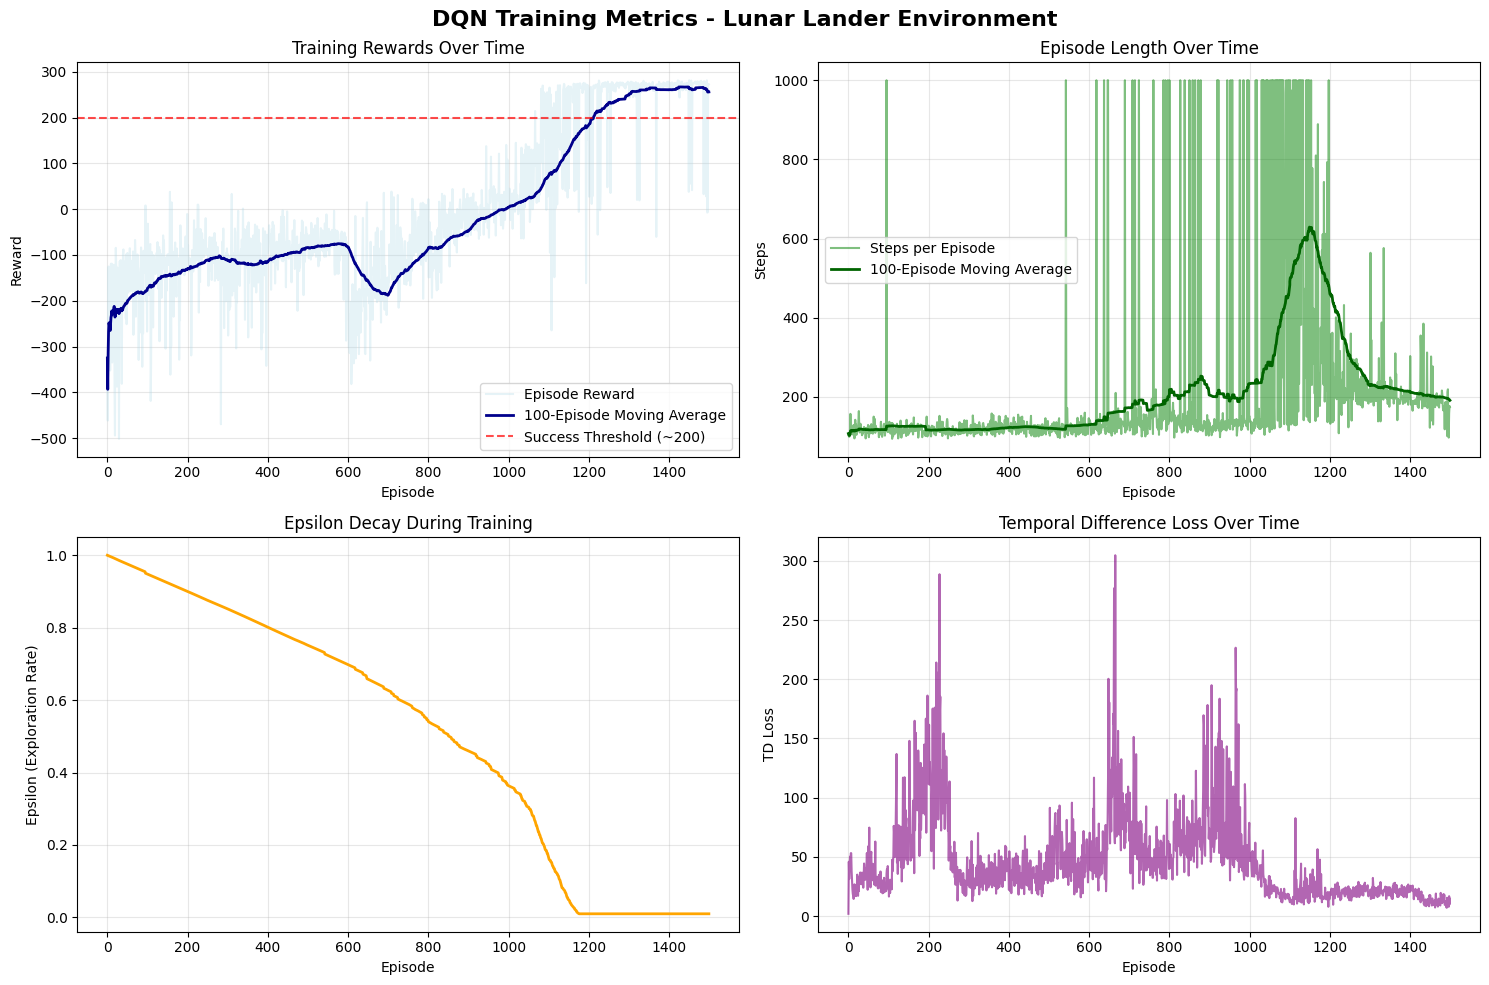

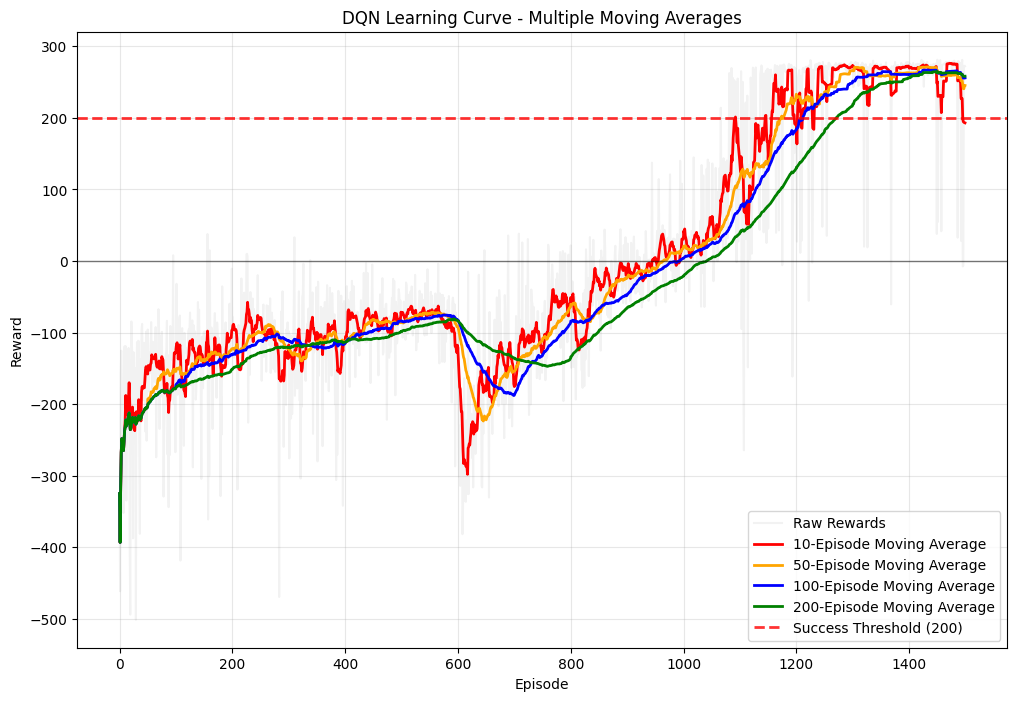

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
training_data = pd.read_csv('logs/training_log.csv')
print(f"Total episodes logged: {len(training_data)}")
print(f"Training duration: {training_data.shape[0]} episodes")

# rolling averages
training_data['reward_ma_100'] = training_data['reward'].rolling(window=100, min_periods=1).mean()
training_data['steps_ma_100'] = training_data['steps'].rolling(window=100, min_periods=1).mean()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DQN Training Metrics - Lunar Lander Environment', fontsize=16, fontweight='bold')

axes[0,0].plot(training_data['episode'], training_data['reward'], alpha=0.3, color='lightblue', label='Episode Reward')
axes[0,0].plot(training_data['episode'], training_data['reward_ma_100'], color='darkblue', linewidth=2, label='100-Episode Moving Average')
axes[0,0].axhline(y=200, color='red', linestyle='--', alpha=0.7, label='Success Threshold (~200)')
axes[0,0].set_xlabel('Episode')
axes[0,0].set_ylabel('Reward')
axes[0,0].set_title('Training Rewards Over Time')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(training_data['episode'], training_data['steps'], alpha=0.5, color='green', label='Steps per Episode')
axes[0,1].plot(training_data['episode'], training_data['steps_ma_100'], color='darkgreen', linewidth=2, label='100-Episode Moving Average')
axes[0,1].set_xlabel('Episode')
axes[0,1].set_ylabel('Steps')
axes[0,1].set_title('Episode Length Over Time')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(training_data['episode'], training_data['epsilon'], color='orange', linewidth=2)
axes[1,0].set_xlabel('Episode')
axes[1,0].set_ylabel('Epsilon (Exploration Rate)')
axes[1,0].set_title('Epsilon Decay During Training')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(training_data['episode'], training_data['td_loss'], alpha=0.6, color='purple')
axes[1,1].set_xlabel('Episode')
axes[1,1].set_ylabel('TD Loss')
axes[1,1].set_title('Temporal Difference Loss Over Time')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
window_sizes = [10, 50, 100, 200]
colors = ['red', 'orange', 'blue', 'green']

plt.figure(figsize=(12, 8))
plt.plot(training_data['episode'], training_data['reward'], alpha=0.1, color='gray', label='Raw Rewards')

for window, color in zip(window_sizes, colors):
    if len(training_data) >= window:
        smoothed = training_data['reward'].rolling(window=window, min_periods=1).mean()
        plt.plot(training_data['episode'], smoothed, color=color, linewidth=2,
                label=f'{window}-Episode Moving Average')

plt.axhline(y=200, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Success Threshold (200)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Learning Curve - Multiple Moving Averages')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()